### 1. Random Forest

Create the probability .csv file

In [2]:
import pandas as pd
import CONSTANT

df = pd.read_csv(CONSTANT.PATH_TO_TRAIN_CSV)

vote_cols = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]

# Normalize the votes to get probabilities
df["total_votes"] = df[vote_cols].sum(axis=1)
for col in vote_cols:
    df[col + "_prob"] = df[col] / df["total_votes"]

# Keep only needed columns
final_df = df[["eeg_id", "spectrogram_id", "expert_consensus"] + [col + "_prob" for col in vote_cols]]

# Drop duplicate eeg_ids — keep the first
# final_df = final_df.drop_duplicates(subset="eeg_id", keep="first")

# Save to new CSV
final_df.to_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/random_forest_saved_data/eeg_vote_probs_grouped.csv", index=False)

Random Forest Model

In [3]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
# Feature extraction from each EEG .parquet file
def extract_features_from_parquet(parquet_path):
    df = pd.read_parquet(parquet_path, columns=["Fp1", "O1", "O2", "Fp2"])

    features = {}
    for col in ["Fp1", "O1", "O2", "Fp2"]:
        features[f"{col}_mean"] = df[col].mean()
        features[f"{col}_std"] = df[col].std()
        features[f"{col}_min"] = df[col].min()
        features[f"{col}_max"] = df[col].max()
    
    return features

In [5]:
# Load the CSV
meta_df = pd.read_csv("/Users/Patron/Documents/brain-waves-classification/hms_data/random_forest_saved_data/eeg_vote_probs_grouped.csv")

# Map expert consensus to integer labels
label_map = {label: i for i, label in enumerate(meta_df['expert_consensus'].unique())}
meta_df['label'] = meta_df['expert_consensus'].map(label_map)

In [6]:
# Loop through all EEGs and build dataset
data = []
labels = []

for _, row in meta_df.iterrows():
    eeg_id = row["eeg_id"]
    parquet_file = CONSTANT.PATH_TO_FILES_TRAIN_EEG+f"/{eeg_id}.parquet"
    
    if os.path.exists(parquet_file):
        features = extract_features_from_parquet(parquet_file)
        data.append(features)
        labels.append(row["label"])
    else:
        print(f"File not found: {parquet_file}")

In [7]:
features_df = pd.DataFrame(data)
labels = np.array(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.3, random_state=42)

In [9]:
# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [10]:
# Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_map.keys()))

              precision    recall  f1-score   support

     Seizure       0.93      0.93      0.93      6265
         GPD       0.97      0.96      0.96      5088
        LRDA       0.95      0.97      0.96      5040
       Other       0.89      0.90      0.90      5662
        GRDA       0.98      0.96      0.97      5631
         LPD       0.90      0.91      0.91      4354

    accuracy                           0.94     32040
   macro avg       0.94      0.94      0.94     32040
weighted avg       0.94      0.94      0.94     32040



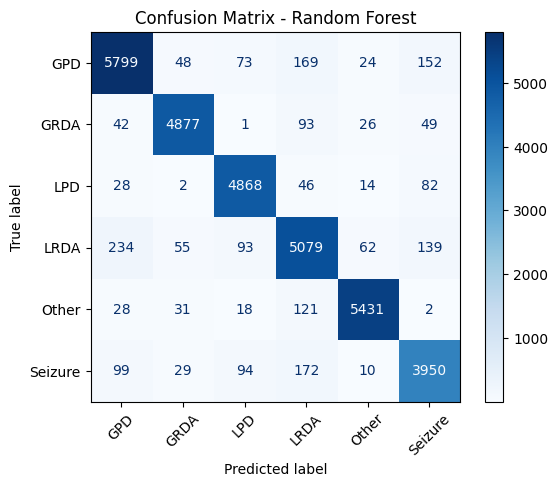

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

le = LabelEncoder()
le.fit(meta_df['expert_consensus'])  # or whatever DataFrame you're using
class_names = ["GPD", "GRDA", "LPD", "LRDA", "Other", "Seizure"]

cm_rf = confusion_matrix(y_test, y_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_names)
disp_rf.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()
